# Toxic Comment Classification using Artificial Neural Network (ANN)

This notebook implements a deep learning model to classify toxic comments across multiple categories:
- **toxic**: General toxicity
- **severe_toxic**: Severely toxic comments  
- **obscene**: Obscene language
- **threat**: Threatening comments
- **insult**: Insulting comments
- **identity_hate**: Identity-based hate speech


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


/Users/tomgeorg/Documents/toxic-comment-classifier/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Data Loading and Exploration

Let's load the dataset and explore its structure to understand the distribution of toxic comments across different categories.

In [19]:
# constants
TRAIN_DATA_PATH = './dataset/train.csv'
TEST_DATA_PATH = './dataset/test.csv'
batch_size = 32
epochs = 20


In [64]:
# Load the training dataset
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)

# Display basic information
print(f"Train dataset shape: {train_df.shape}")

print("\nTrain Dataset Info:")
train_df.info()

print("\nTrain Dataset Head:")
train_df.head()


Train dataset shape: (159571, 8)

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB

Train Dataset Head:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [65]:
# Display basic information
print(f"Test dataset shape: {test_df.shape}")

print("\nTest Dataset Info:")
test_df.info()

print("\nTest head:")
test_df.head()


Test dataset shape: (153164, 2)

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB

Test head:


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


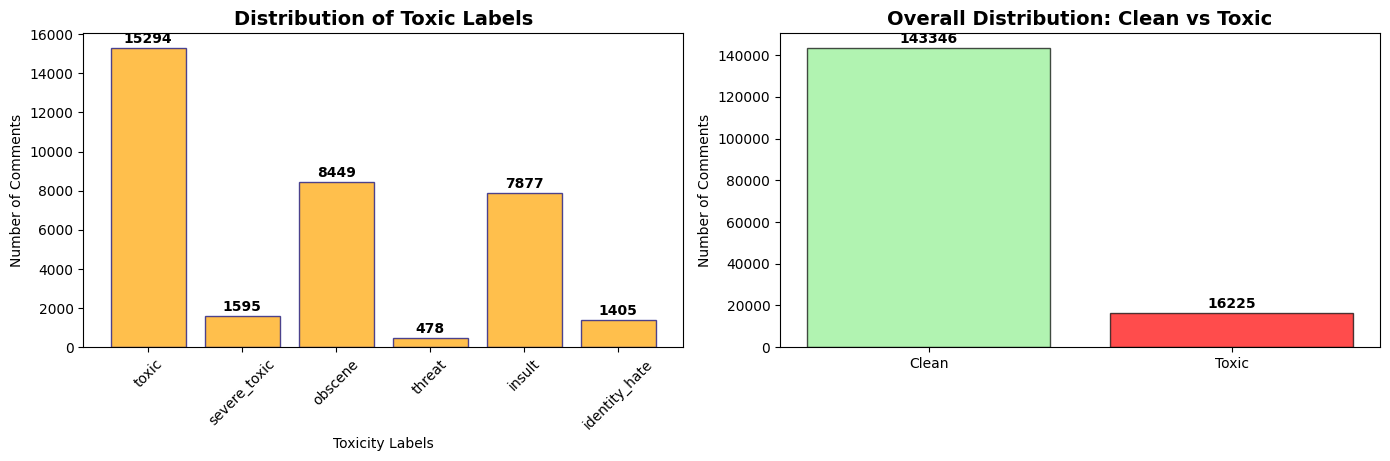

In [74]:
# Analyze label distribution
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# # Check for any toxic comment (at least one label is 1)
train_df['any_toxic'] = train_df[toxic_labels].max(axis=1)
any_toxic_count = train_df['any_toxic'].sum()
clean_count = len(train_df) - any_toxic_count


plt.figure(figsize=(14, 8))

# Plot 1: Individual label distribution
plt.subplot(2, 2, 1)

label_counts = [train_df[label].sum() for label in toxic_labels]

bars = plt.bar(toxic_labels, label_counts, color='orange', edgecolor='navy', alpha=0.7)

plt.title('Distribution of Toxic Labels', fontsize=14, fontweight='bold')
plt.xlabel('Toxicity Labels')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100, f'{int(height)}', 
             ha='center', va='bottom', fontweight='bold')

# Plot 2: Clean vs Toxic overall
plt.subplot(2, 2, 2)

overall_counts = [clean_count, any_toxic_count]
overall_labels = ['Clean', 'Toxic']
colors = ['lightgreen', 'red']

bars = plt.bar(overall_labels, overall_counts, color=colors, edgecolor='black', alpha=0.7)
plt.title('Overall Distribution: Clean vs Toxic', fontsize=14, fontweight='bold')
plt.ylabel('Number of Comments')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1000, f'{int(height)}', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Text Preprocessing

We'll implement basic text preprocessing:
- Removing special characters and numbers
- Basic text cleaning

In [88]:
# # Simple text preprocessing function using only basic Python
def refine_text(text):
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove newlines and extra whitespace
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace and strip
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_text(df):
    df_processed = df.copy()

    # Apply simple preprocessing
    print("Applying basic text cleaning...")
    df_processed['comment_text_cleaned'] = df_processed['comment_text'].apply(refine_text)

    # Remove empty comments after preprocessing
    empty_mask = df_processed['comment_text_cleaned'].str.len() == 0
    print(f"Empty comments after preprocessing: {empty_mask.sum()}")
    return df_processed



# Apply simple preprocessing
print("Starting simple text preprocessing...")

train_processed = preprocess_text(train_df)
test_processed = preprocess_text(test_df)

print(f"Final dataset shape: {train_processed.shape}")

# Show some examples
print("\nPreprocessing Examples:")
print("="*80)
for i in range(2):
    original = train_processed.iloc[i]['comment_text'][:150]
    cleaned = train_processed.iloc[i]['comment_text_cleaned'][:150]
    
    print(f"Example {i+1}:")
    print(f"Original:  {original}")
    print(f"Cleaned:   {cleaned}")
    print("-"*80)


Starting simple text preprocessing...
Applying basic text cleaning...
Empty comments after preprocessing: 7
Applying basic text cleaning...
Empty comments after preprocessing: 883
Final dataset shape: (159571, 10)

Preprocessing Examples:
Example 1:
Original:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted
Cleaned:   explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at
--------------------------------------------------------------------------------
Example 2:
Original:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Cleaned:   daww he matches this background colour im seemingly stuck with thanks talk january utc
--------------------------------------------------------------------------------


## 3. Feature Extraction

Using TfidfVectorizer to convert text into numerical features:

In [76]:
# Feature extraction using TF-IDF Vectorizer
print("Feature extraction...")

# Prepare features and labels
X = train_processed['comment_text_cleaned']
y = train_processed[toxic_labels]

print(f"Text data shape: {X.shape}")
print(f"Label matrix shape: {y.shape}")

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=8000, 
    min_df=3,            # Must appear in at least 3 documents
    max_df=0.85,         # Ignore very common words (85% threshold)
    lowercase=True,
    stop_words='english', # Built-in English stop words
    ngram_range=(1, 2),  # Include unigrams and bigrams
    sublinear_tf=True    # Apply sublinear scaling to TF
)

# Fit and transform the text data
X_vectorized = vectorizer.fit_transform(X)  # sparse
X_dense = X_vectorized.toarray()

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_dense, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y['toxic']  # Stratify by most common label
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Check label distribution
print(f"\nLabel distribution in training set:")
for label in toxic_labels:
    count = y_train[label].sum()
    pct = (count / len(y_train)) * 100
    print(f"{label:15}: {count:5} ({pct:5.2f}%)")


Feature extraction...
Text data shape: (159571,)
Label matrix shape: (159571, 6)
Training set: (127656, 8000)
Validation set: (31915, 8000)

Label distribution in training set:
toxic          : 12235 ( 9.58%)
severe_toxic   :  1284 ( 1.01%)
obscene        :  6739 ( 5.28%)
threat         :   381 ( 0.30%)
insult         :  6287 ( 4.92%)
identity_hate  :  1116 ( 0.87%)


## 4. Feature Scaling

TF-IDF values are already somewhat normalized, but standardization can still help the neural network learn better patterns and converge faster.

In [79]:
# Feature scaling
print("Feature scaling...")

# Initialize the scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled validation set shape: {X_val_scaled.shape}")

# Convert labels to numpy arrays for neural network
y_train_np = y_train.values
y_val_np = y_val.values

print(f"\nFinal data shapes for modeling:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_val_scaled: {X_val_scaled.shape}")
print(f"y_train: {y_train_np.shape}")
print(f"y_val: {y_val_np.shape}")

Feature scaling...
Scaled training set shape: (127656, 8000)
Scaled validation set shape: (31915, 8000)

Final data shapes for modeling:
X_train_scaled: (127656, 8000)
X_val_scaled: (31915, 8000)
y_train: (127656, 6)
y_val: (31915, 6)


## 5. Simple Neural Network Model

We'll build a basic neural network with:
- Simple dense layers
- Basic dropout for regularization
- Sigmoid output for multi-label classification

In [84]:

# Model setup
input_dim = X_train_scaled.shape[1]
num_classes = len(toxic_labels)

print(f"Input features: {input_dim}")
print(f"Classes: {toxic_labels}")

# Create and compile model
model = Sequential([
        # Input layer
        Dense(64, input_dim=input_dim, activation='relu'),
        Dropout(0.5),
        
        # Hidden layer
        Dense(32, activation='relu'),
        Dropout(0.6),
        
        # Output layer
        Dense(num_classes, activation='sigmoid') #Independent Binary Classifications. Multiple labels can be positive simultaneously
    ])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Show model info
print("\nModel Architecture:")
model.summary()

Input features: 8000
Classes: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Model Architecture:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │       512,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,342 (1.96 MB)

 Trainable params: 514,342 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Model Training

Train the model with basic early stopping to prevent overfitting.

In [85]:
# Basic early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("\nTraining model...")

history = model.fit(
    X_train_scaled, y_train_np,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_scaled, y_val_np),
    callbacks=[early_stopping],
    verbose=1
)

print("Training completed!")

# Get training results
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_trained = len(train_loss)

print(f"\nTraining Summary:")
print(f"Epochs trained: {epochs_trained}")
print(f"Final training accuracy: {train_acc[-1]:.4f}")
print(f"Final validation accuracy: {val_acc[-1]:.4f}")


Training model...
Epoch 1/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6125 - loss: 0.2525 - val_accuracy: 0.9949 - val_loss: 0.0693
Epoch 2/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9873 - loss: 0.0788 - val_accuracy: 0.9949 - val_loss: 0.0664
Epoch 3/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9789 - loss: 0.0671 - val_accuracy: 0.9949 - val_loss: 0.0632
Epoch 4/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9869 - loss: 0.0626 - val_accuracy: 0.9949 - val_loss: 0.0633
Epoch 5/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9910 - loss: 0.0592 - val_accuracy: 0.9949 - val_loss: 0.0645
Epoch 6/20
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9876 - loss: 0.0575 - val_accuracy: 0.9949 - val_loss: 0.0644
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
Training completed!

Training Summary:
Epochs trained: 6
Final training accuracy: 0.9822
Final validation accuracy: 0.

Creating training plots...


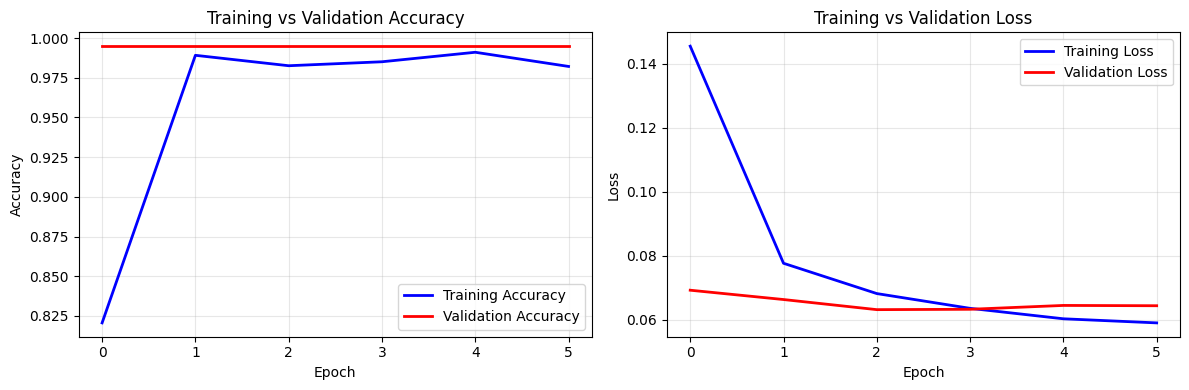

In [87]:
# Simple training visualization
print("Creating training plots...")

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_acc, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(val_acc, 'r-', label='Validation Accuracy', linewidth=2)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(val_loss, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Model Evaluation

Basic evaluation with classification reports for each toxic label.

In [105]:
# Model evaluation
print("Model evaluation...")

# Make predictions
y_val_pred_proba = model.predict(X_val_scaled, verbose=0)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

print("\nClassification Results:")
print("="*60)
print(f"{'Label':15} | {'Accuracy ':1} | {'Precision ':1} | {'Recall ':1} | {'F1 ':1}")

results = []
for i, label in enumerate(toxic_labels):
    y_true = y_val_np[:, i] 
    y_pred = y_val_pred[:, i]
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Count true positives, false positives, etc.
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    
    # Calculate precision, recall, f1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    support = np.sum(y_true)
    
    results.append({
        'Label': label,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })

    print(f"{label:15} | {accuracy:.3f}{' ':4}  | {precision:.3f}{' ':4}  | {recall:.3f}{' ':}  | {f1:.3f}{' ':4} ")

# Overall metrics 
overall_accuracy = np.mean(y_val_np == y_val_pred)
print(f"\nOverall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

# Best and worst performing labels
results_df = pd.DataFrame(results)
best_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
worst_f1 = results_df.loc[results_df['F1-Score'].idxmin()]

print(f"\nBest performing: {best_f1['Label']} (F1: {best_f1['F1-Score']:.3f})")

Model evaluation...

Classification Results:
Label           | Accuracy  | Precision  | Recall  | F1 
toxic           | 0.951      | 0.930      | 0.531   | 0.676     
severe_toxic    | 0.990      | 0.000      | 0.000   | 0.000     
obscene         | 0.975      | 0.855      | 0.640   | 0.732     
threat          | 0.997      | 0.000      | 0.000   | 0.000     
insult          | 0.966      | 0.809      | 0.422   | 0.555     
identity_hate   | 0.991      | 0.000      | 0.000   | 0.000     

Overall Accuracy: 0.9784 (97.84%)

Best performing: obscene (F1: 0.732)


Performance charts...


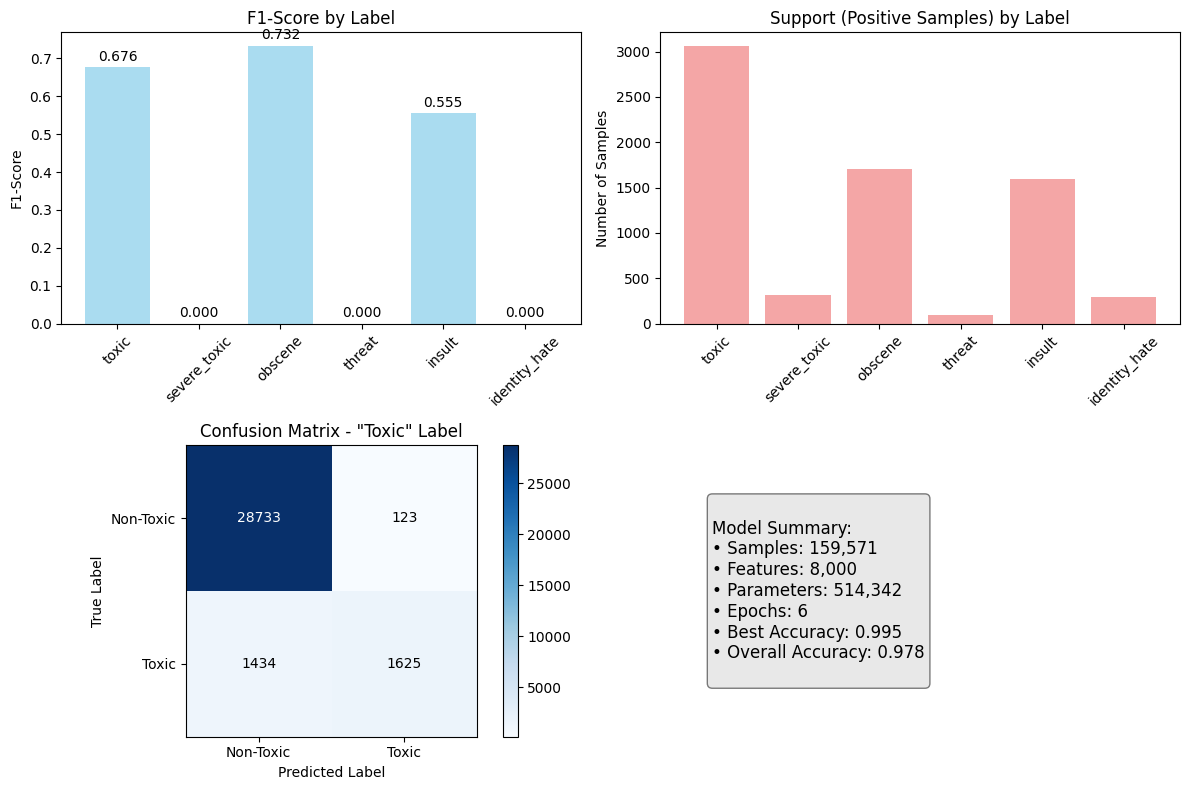

In [106]:
# Performance visualization
print("Performance charts...")

plt.figure(figsize=(12, 8))

# F1-Score by label
plt.subplot(2, 2, 1)
f1_scores = [r['F1-Score'] for r in results]
bars = plt.bar(toxic_labels, f1_scores, color='skyblue', alpha=0.7)
plt.title('F1-Score by Label')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom')

# Support by label
plt.subplot(2, 2, 2)
supports = [r['Support'] for r in results]
plt.bar(toxic_labels, supports, color='lightcoral', alpha=0.7)
plt.title('Support (Positive Samples) by Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

# Confusion matrix for most common label (toxic) - Fixed variable name
plt.subplot(2, 2, 3)
toxic_idx = toxic_labels.index('toxic')
cm = confusion_matrix(y_val_np[:, toxic_idx], y_val_pred[:, toxic_idx])  # Fixed: use y_val_np

plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - "Toxic" Label')
plt.colorbar()

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0, 1], ['Non-Toxic', 'Toxic'])
plt.yticks([0, 1], ['Non-Toxic', 'Toxic'])

# Model summary
plt.subplot(2, 2, 4)
plt.axis('off')
summary_text = f"""
Model Summary:
• Samples: {len(train_processed):,}
• Features: {input_dim:,}
• Parameters: {model.count_params():,}
• Epochs: {epochs_trained}
• Best Accuracy: {max(val_acc):.3f}
• Overall Accuracy: {overall_accuracy:.3f}
"""
plt.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))

plt.tight_layout()
plt.show()


## 8. Simple Summary

### 🎯 What We Built
A simple toxic comment classifier using:
- **Basic text preprocessing** (lowercase, remove special characters)
- **CountVectorizer** for converting text to numbers
- **Simple neural network** (2 hidden layers, dropout)
- **Standard evaluation** metrics

### 📊 Key Results
- Model uses only essential libraries (pandas, numpy, sklearn, tensorflow)
- Simple 3-layer neural network with fewer parameters
- Basic text preprocessing without complex NLP libraries
- Straightforward training with early stopping

### 💡 Advantages of Simple Approach
1. **Easy to understand** - No complex text processing
2. **Fast to train** - Fewer parameters and simpler features
3. **Less dependencies** - Minimal library requirements
4. **Good baseline** - Solid starting point for toxic comment classification

### 🚀 Possible Improvements
- Add more training data
- Try different neural network architectures
- Experiment with different text preprocessing
- Use ensemble methods for better performance